In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir('/content/drive/My Drive/network/data')

Mounted at /content/drive


In [ ]:
!pip install pyspark 
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64" 


     |████████████████████████████████| 212.3MB 32kB/s 
     |████████████████████████████████| 204kB 43.0MB/s 
  Created wheel for pyspark: filename=pyspark-3.1.1-py2.py3-none-any.whl size=212767604 sha256=7c217aca907154658c77121fa175a7594c9459fadeffb508d8a9cc4e39e13c47
  Stored in directory: /root/.cache/pip/wheels/0b/90/c0/01de724414ef122bd05f056541fb6a0ecf47c7ca655f8b3c0f
Successfully built pyspark
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra
  fonts-ipafont-gothic fonts-ipafont-mincho fonts-wqy-microhei
  fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 2 newly installed, 0 to remove and 34 not upgraded.
Need to get 36.5 MB of archives.
After this 

In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq 

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [53.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/cran/

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

In [ ]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

In [ ]:
from pyspark.sql.functions import date_add, col
from pyspark.sql.functions import min, max, avg
from pyspark.sql.functions import datediff
from pyspark.sql.functions import lit

# subsample data by its weight record duration 
1. know their first record and last record date
2. count date duration 
3. plot distribution of the date difference  

total record is 3952879 and record duration less than 10 days is 2794353(70.7%) 

also record duration greater than 400 days is 138191(3.5%)

4. subsample the data by filtering duration days between 300-400 and finally get 298497(7.6%) users 

In [ ]:
weight_record_consolidated=spark.read.option("header", "true").option("inferSchema","true").option("timestampFormat", "yyyy-mm-dd").csv("weight_record_consolidated.csv")

In [ ]:
period=weight_record_consolidated.groupby(['user_id']).agg(max("date"),min("date"))
period = period.withColumn("cal_date_diff", datediff(col('max(date)'), col('min(date)'))) 
period = period.withColumn('cal_date_diffs', (period['cal_date_diff'] + lit(1)))
period=period.select("user_id","cal_date_diffs")

In [ ]:
period=period.toPandas()


In [ ]:
print(period['cal_date_diffs'].max())
print(period['cal_date_diffs'].min())
print(period['cal_date_diffs'].mean())
print(period['cal_date_diffs'].std())

2953
1
73.56408405114348
243.1336236889218


In [ ]:
period["user_id"].count

<bound method Series.count of 0               148
1               463
2               471
3               496
4               833
             ...   
3952874    12312980
3952875    12318235
3952876    12329702
3952877    12330681
3952878    12335304
Name: user_id, Length: 3952879, dtype: int32>

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


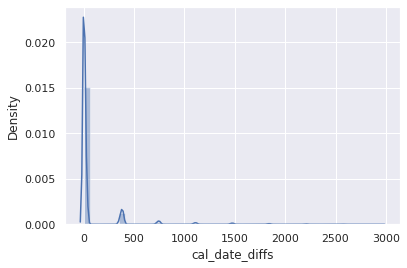

In [ ]:
sns.set()
ax = sns.distplot(period['cal_date_diffs'])

In [ ]:
period[period['cal_date_diffs'] <10 ].count()

user_id           2794353
cal_date_diffs    2794353
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


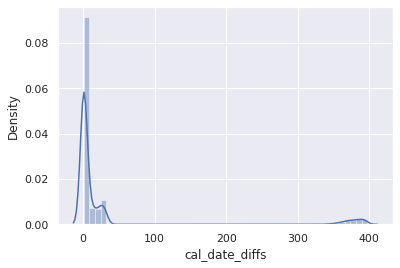

In [ ]:
sns.set()
a=period[period['cal_date_diffs'] <500 ]
ax = sns.distplot(a['cal_date_diffs'])

In [ ]:
period[period['cal_date_diffs'] >400 ].count()

user_id           138191
cal_date_diffs    138191
dtype: int64

In [ ]:
b=period[(period['cal_date_diffs']<400) & (period['cal_date_diffs']>300)]

In [ ]:
print(b['cal_date_diffs'].max())
print(b['cal_date_diffs'].min())
print(b['cal_date_diffs'].mean())
print(b['cal_date_diffs'].std())

397
336
377.95994599610714
13.04684562979938


In [ ]:
period[(period['cal_date_diffs']<400) & (period['cal_date_diffs']>300)].count()

user_id           298497
cal_date_diffs    298497
dtype: int64

In [ ]:
period[(period['cal_date_diffs']<400) & (period['cal_date_diffs']>300)]

,user_id,cal_date_diffs
0,148,395
1,463,392
7,1342,393
9,1591,374
12,1959,395
...,...,...
3950947,11624947,388
3951501,11845276,368
3951783,11940568,371
3952298,12106839,385


In [ ]:
sub_df=period[(period['cal_date_diffs']<400) & (period['cal_date_diffs']>300)]

In [ ]:
len(pd.unique(sub_df['user_id']))

298497

# feature engineering prespare 

1. total 298497 users in our subsample dataset merge with weight dataset 
2. use merged dataset to find the min date of record 
3. then adding 150 days to be the cutoff of features 
4. join this to each datesets and drop all the features later than 150 days 

In [ ]:
sub_df=spark.createDataFrame(sub_df) 
feature_cutoff = sub_df.join(weight_record_consolidated, ["user_id"],how='left') 


In [ ]:
feature_cutoff.show()

+-------+--------------+------+----------+-------------------+
|user_id|cal_date_diffs|weight| record_on|               date|
+-------+--------------+------+----------+-------------------+
|     26|           396|  77.0|2013-04-11|2013-01-11 00:04:00|
|     26|           396|  76.1|2013-04-17|2013-01-17 00:04:00|
|     26|           396|  76.3|2013-04-18|2013-01-18 00:04:00|
|     26|           396|  75.7|2013-04-19|2013-01-19 00:04:00|
|     26|           396|  75.2|2013-04-20|2013-01-20 00:04:00|
|     26|           396|  75.5|2013-04-21|2013-01-21 00:04:00|
|     26|           396|  75.4|2013-04-22|2013-01-22 00:04:00|
|     26|           396|  75.1|2013-04-23|2013-01-23 00:04:00|
|     26|           396|  74.9|2013-04-24|2013-01-24 00:04:00|
|     26|           396|  74.9|2013-04-25|2013-01-25 00:04:00|
|     26|           396|  74.9|2013-04-26|2013-01-27 00:04:00|
|     26|           396|  74.3|2013-04-27|2013-01-27 00:04:00|
|     26|           396|  74.2|2013-04-28|2013-01-28 00

In [ ]:
feature_cutoff.select('user_id').distinct().count()

298497

In [ ]:
feature_cutoff.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- cal_date_diffs: long (nullable = true)
 |-- weight: double (nullable = true)
 |-- record_on: string (nullable = true)
 |-- date: timestamp (nullable = true)



In [ ]:
feature_cutoff=feature_cutoff.groupby(['user_id']).agg(min("date"))
feature_cutoff= feature_cutoff.withColumn("cutoff", date_add(feature_cutoff['min(date)'], 150))


In [ ]:
feature_cutoff=feature_cutoff.select("user_id","cutoff")


In [ ]:
#user_list=list(feature_cutoff.select('user_id').toPandas()["user_id"])

# Calory records including eating and activity 
1. sum eating calory, sum activity calory 
2. count date difference 
3. cal the  calory intake each time 

  

In [ ]:
can_record_consolidated = spark.read.option("header", "true").option("inferSchema","true").option("timestampFormat", "yyyy-mm-dd").csv("can_record_consolidated.csv")


In [ ]:
can_record_consolidated=feature_cutoff.join(can_record_consolidated, ["user_id"],how='left')    
can_record_consolidated = can_record_consolidated.withColumn("cal_date_diff", datediff(col('cutoff'), col('record_on'))) 
can_record_consolidated=can_record_consolidated.filter(can_record_consolidated["cal_date_diff"]>0)

In [ ]:
calory=can_record_consolidated.groupby(['user_id']).agg({'eating_calory': 'sum','activity_calory': 'sum'})

In [ ]:
freq=can_record_consolidated.groupby(['user_id']).count()


In [ ]:
calory_record = calory.join(freq, ["user_id"],how='left') # Could also use 'left_outer'

In [ ]:
calory_record= calory_record.withColumnRenamed("sum(eating_calory)","sum_eating_calory")
calory_record= calory_record.withColumnRenamed("sum(activity_calory)","sum_activity_calory")
calory_record = calory_record.withColumn("calory_intake_freq", (col("sum_eating_calory")-col("sum_activity_calory"))/col("count"))
calory_record=calory_record.select("user_id","calory_intake_freq")

In [ ]:
del can_record_consolidated 
del calory
del period

# comment and post 

这个user 评论别人 

In [ ]:
comment_consolidated=spark.read.option("header", "true").option("inferSchema","true").option("timestampFormat", "yyyy-mm-dd").csv("comment_consolidated.csv")


In [ ]:
#comment_consolidated.filter(comment_consolidated.user_id.isin(user_list)).show()
#comment_consolidated = comment_consolidated.where(comment_consolidated.user_id in user_list)

In [ ]:
comment_consolidated=feature_cutoff.join(comment_consolidated, ["user_id"],how='left') 
comment_consolidated = comment_consolidated.withColumn("cal_date_diff", datediff(col('cutoff'), col('date'))) 
comment_consolidated=comment_consolidated.filter(comment_consolidated["cal_date_diff"]>0)

In [ ]:
period=comment_consolidated.groupby(['user_id']).agg(max("date"),min("date"))
period = period.withColumn("cal_date_diff", datediff(col('max(date)'), col('min(date)'))) 
period=period.select("user_id","cal_date_diff")

In [ ]:
from pyspark.sql.functions import countDistinct
comment_consolidated = comment_consolidated.groupBy("user_id").agg(countDistinct("post_id").alias("post_counts"),countDistinct("comment_id").alias("comment_counts"))

In [ ]:
comment= comment_consolidated.join(period, ["user_id"],how='left') 


In [ ]:
comment = comment.withColumn('cal_date_diffs', (comment['cal_date_diff'] + lit(1)))
comment = comment.withColumn("daily_post_count", col("post_counts")/col("cal_date_diffs"))
comment = comment.withColumn("daily_comment_count", col("comment_counts")/col("cal_date_diffs"))
comment=comment.select("user_id" , "daily_post_count","daily_comment_count")


In [ ]:
del comment_consolidated
del period

# order 

In [ ]:
order_detail_record_consolidated=spark.read.option("header", "true").option("inferSchema","true").option("timestampFormat", "yyyy-mm-dd").csv("order_detail_record_consolidated.csv")

In [ ]:
order_detail_record_consolidated=feature_cutoff.join(order_detail_record_consolidated, ["user_id"],how='left') 
order_detail_record_consolidated = order_detail_record_consolidated.withColumn("cal_date_diff", datediff(col('cutoff'), col('created_at'))) 
order_detail_record_consolidated=order_detail_record_consolidated.filter(order_detail_record_consolidated["cal_date_diff"]>0)

In [ ]:
price=order_detail_record_consolidated.groupby(['user_id']).agg({'price_each_goods': 'sum'})

In [ ]:
orders=order_detail_record_consolidated.groupBy("user_id").agg(countDistinct("order_id").alias("order_counts"))

In [ ]:
order_spend = price.join(orders, ["user_id"],how='left')

In [ ]:
order_spend = order_spend.withColumn("spend_per_order", col("sum(price_each_goods)")/col("order_counts"))
order_spend= order_spend.select("user_id","spend_per_order","order_counts")


# User profile 

In [ ]:
userprofile=spark.read.option("header", "true").option("inferSchema","true").option("timestampFormat", "yyyy-mm-dd").csv("userprofile.csv")


In [ ]:
users_consolidated=spark.read.option("header", "true").option("inferSchema","true").option("timestampFormat", "yyyy-mm-dd").csv("users_consolidated.csv")


In [ ]:
user2=users_consolidated.select("id","birthday","location","weight","target_date","latest_weight","bmi","created_at")

In [ ]:
profile = userprofile.join(user2, userprofile.user_id == user2.id,how='left')

In [ ]:
profile=profile.drop("id")

In [ ]:
profile=feature_cutoff.join(profile, ["user_id"],how='left') 

# wrangling dataset 
1. merge into a complete large dataset 
2. divide age groups 
3. group by gender and age groups fill na with mean
4. drop the wrong date

# merge dataset 

In [ ]:
profile=profile.toPandas()
calory_record=calory_record.toPandas()
comment=comment.toPandas()
order_spend=order_spend.toPandas()

In [ ]:
weight=pd.read_csv("weight_record_consolidated.csv")
weight.head()

,user_id,weight,record_on,date
0,1,56.0,2013-02-28,2013-02-28
1,1,84.0,2013-03-17,2013-03-17
2,1,63.9,2013-03-18,2013-03-18
3,1,70.2,2013-10-01,2013-10-01
4,1,66.0,2013-10-31,2013-10-31


In [ ]:
a = profile.merge(calory_record, on="user_id" ,how='left')
b = a.merge(comment,on="user_id" ,how='left')
c = b.merge(order_spend,on="user_id",how='left')
final_df = c.merge(weight,on="user_id",how='left')



In [ ]:
final_df

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date
0,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,77.0,2013-04-11,2013-04-11
1,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,76.1,2013-04-17,2013-04-17
2,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,76.3,2013-04-18,2013-04-18
3,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,75.7,2013-04-19,2013-04-19
4,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,75.2,2013-04-20,2013-04-20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887476,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,NaN,NaN,NaN,NaN,49.5,2015-05-15,2015-05-16
6887477,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,NaN,NaN,NaN,NaN,49.3,2015-05-16,2015-05-16
6887478,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,NaN,NaN,NaN,NaN,49.0,2015-05-17,2015-05-17
6887479,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,NaN,NaN,NaN,NaN,49.3,2015-05-18,2015-05-18


In [ ]:
final_df.isna().sum() 

user_id                      0
cutoff                       0
avatar                       0
gendar                       0
height                       0
target_weight                0
lastdays                     0
AvgPost                      0
AvgComment                   0
AvgMention                   0
age                          0
hasPost                      0
hasComment                   0
hasMention                   0
hasHeight                    0
hasWeightTarget              0
birthday                     0
location               4438751
weight_x                     0
target_date                  0
latest_weight                0
bmi                          0
created_at                   0
calory_intake_freq     4183359
daily_post_count       4784844
daily_comment_count    4784844
spend_per_order        6884984
order_counts           6884984
weight_y                     0
record_on                    0
date                         0
dtype: int64

# generate age group and fill in na with grouped age and gender's mean 

In [ ]:
print(final_df["age"].max())
print(final_df["age"].min())
print(final_df["age"].mean())
print(final_df["age"].std())

2013
-517
26.427387313300756
16.04676832296806


In [ ]:
final_df=final_df[(final_df['age'] > 5) & (final_df['age'] < 100)]

In [ ]:

bins = [0, 10, 20, 30, 40, 55, 70,100]
labels = [9, 19, 29, 39, 54, 69,70]
final_df['agerange'] = pd.cut(final_df.age, bins, labels = labels,include_lowest = True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
final_df

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange
0,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,77.0,2013-04-11,2013-04-11,29
1,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,76.1,2013-04-17,2013-04-17,29
2,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,76.3,2013-04-18,2013-04-18,29
3,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,75.7,2013-04-19,2013-04-19,29
4,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,NaN,NaN,NaN,NaN,75.2,2013-04-20,2013-04-20,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887476,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,NaN,NaN,NaN,NaN,49.5,2015-05-15,2015-05-16,29
6887477,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,NaN,NaN,NaN,NaN,49.3,2015-05-16,2015-05-16,29
6887478,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,NaN,NaN,NaN,NaN,49.0,2015-05-17,2015-05-17,29
6887479,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,NaN,NaN,NaN,NaN,49.3,2015-05-18,2015-05-18,29


In [ ]:
final_df.dtypes

user_id                   int64
cutoff                   object
avatar                    int32
gendar                    int32
height                  float64
target_weight           float64
lastdays                  int32
AvgPost                 float64
AvgComment              float64
AvgMention              float64
age                       int32
hasPost                   int32
hasComment                int32
hasMention                int32
hasHeight                 int32
hasWeightTarget           int32
birthday                 object
location                 object
weight_x                 object
target_date              object
latest_weight            object
bmi                     float64
created_at               object
calory_intake_freq      float64
daily_post_count        float64
daily_comment_count     float64
spend_per_order         float64
order_counts            float64
weight_y                float64
record_on                object
date                     object
agerange

In [ ]:
final_df["calory_intake_freq"] = final_df.groupby(["gendar","agerange"])["calory_intake_freq"].transform(lambda x: x.fillna(x.mean()))

final_df["daily_post_count"] = final_df.groupby(["gendar","agerange"])["daily_post_count"].transform(lambda x: x.fillna(x.mean()))

final_df["daily_comment_count"] = final_df.groupby(["gendar","agerange"])["daily_comment_count"].transform(lambda x: x.fillna(x.mean()))

final_df["spend_per_order"] = final_df.groupby(["gendar","agerange"])["spend_per_order"].transform(lambda x: x.fillna(x.mean()))

final_df["order_counts"] = final_df.groupby(["gendar","agerange"])["order_counts"].transform(lambda x: x.fillna(x.mean()))






/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [ ]:
final_df["intake_back"] = final_df.groupby(["agerange"])["calory_intake_freq"].transform(lambda x: x.fillna(x.mean()))

final_df["post_back"] = final_df.groupby(["agerange"])["daily_post_count"].transform(lambda x: x.fillna(x.mean()))

final_df["comment_back"] = final_df.groupby(["agerange"])["daily_comment_count"].transform(lambda x: x.fillna(x.mean()))

final_df["spend_back"] = final_df.groupby(["agerange"])["spend_per_order"].transform(lambda x: x.fillna(x.mean()))

final_df["order_back"] = final_df.groupby(["agerange"])["order_counts"].transform(lambda x: x.fillna(x.mean()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

In [ ]:
final_df["calory_intake_freq"].fillna(final_df["intake_back"], inplace=True)

final_df["daily_post_count"].fillna(final_df["post_back"], inplace=True)

final_df["daily_comment_count"].fillna(final_df["comment_back"], inplace=True)

final_df["spend_per_order"].fillna(final_df["spend_back"], inplace=True)

final_df["order_counts"].fillna(final_df["order_back"], inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
final_df["spend_per_order"].fillna((final_df["spend_per_order"].mean()), inplace=True)

final_df["order_counts"].fillna((final_df["order_counts"].mean()), inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [ ]:
final_df.isna().sum() 

user_id                      0
cutoff                       0
avatar                       0
gendar                       0
height                       0
target_weight                0
lastdays                     0
AvgPost                      0
AvgComment                   0
AvgMention                   0
age                          0
hasPost                      0
hasComment                   0
hasMention                   0
hasHeight                    0
hasWeightTarget              0
birthday                     0
location               4374288
weight_x                     0
target_date                  0
latest_weight                0
bmi                          0
created_at                   0
calory_intake_freq           0
daily_post_count             0
daily_comment_count          0
spend_per_order              0
order_counts                 0
weight_y                     0
record_on                    0
date                         0
agerange                     0
intake_b

# drop wrong date 

In [ ]:
final_df.drop(final_df[final_df['record_on'] >'2019-01-01'].index, inplace = True)
final_df.drop(final_df[final_df['record_on'] <'2007-01-01'].index, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1. clean the data
2. calculate weight_loss
3. cluster the weigh loss into 1,0 



In [ ]:
final_df

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back
0,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,77.0,2013-04-11,2013-04-11,29,870.400000,2.315757,4.156579,42.087528,2.188645
1,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,76.1,2013-04-17,2013-04-17,29,870.400000,2.315757,4.156579,42.087528,2.188645
2,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,76.3,2013-04-18,2013-04-18,29,870.400000,2.315757,4.156579,42.087528,2.188645
3,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,75.7,2013-04-19,2013-04-19,29,870.400000,2.315757,4.156579,42.087528,2.188645
4,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,75.2,2013-04-20,2013-04-20,29,870.400000,2.315757,4.156579,42.087528,2.188645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887476,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.5,2015-05-15,2015-05-16,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887477,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.3,2015-05-16,2015-05-16,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887478,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.0,2015-05-17,2015-05-17,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887479,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.3,2015-05-18,2015-05-18,29,528.045455,2.315757,4.156579,42.087528,2.188645


In [ ]:
final_df.dtypes

user_id                   int64
cutoff                   object
avatar                    int32
gendar                    int32
height                  float64
target_weight           float64
lastdays                  int32
AvgPost                 float64
AvgComment              float64
AvgMention              float64
age                       int32
hasPost                   int32
hasComment                int32
hasMention                int32
hasHeight                 int32
hasWeightTarget           int32
birthday                 object
location                 object
weight_x                 object
target_date              object
latest_weight            object
bmi                     float64
created_at               object
calory_intake_freq      float64
daily_post_count        float64
daily_comment_count     float64
spend_per_order         float64
order_counts            float64
weight_y                float64
record_on                object
date                     object
agerange

In [ ]:
final_df['record_on']= pd.to_datetime(final_df['record_on'],format="%Y-%m-%d",errors = 'coerce')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
index_names=final_df[final_df["weight_x"]=='$null$'].index

final_df.drop(index_names, inplace = True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
final_df

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back
0,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,77.0,2013-04-11,2013-04-11,29,870.400000,2.315757,4.156579,42.087528,2.188645
1,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,76.1,2013-04-17,2013-04-17,29,870.400000,2.315757,4.156579,42.087528,2.188645
2,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,76.3,2013-04-18,2013-04-18,29,870.400000,2.315757,4.156579,42.087528,2.188645
3,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,75.7,2013-04-19,2013-04-19,29,870.400000,2.315757,4.156579,42.087528,2.188645
4,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.000,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,75.2,2013-04-20,2013-04-20,29,870.400000,2.315757,4.156579,42.087528,2.188645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887476,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.5,2015-05-15,2015-05-16,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887477,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.3,2015-05-16,2015-05-16,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887478,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.0,2015-05-17,2015-05-17,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887479,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.200,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.3,2015-05-18,2015-05-18,29,528.045455,2.315757,4.156579,42.087528,2.188645


In [ ]:
final_df=final_df.dropna(subset=['record_on'])

In [ ]:
final_df['weight_x'] = final_df['weight_x'].astype(float)

In [ ]:
final_df

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back
0,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.0,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,77.0,2013-04-11,2013-04-11,29,870.400000,2.315757,4.156579,42.087528,2.188645
1,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.0,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,76.1,2013-04-17,2013-04-17,29,870.400000,2.315757,4.156579,42.087528,2.188645
2,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.0,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,76.3,2013-04-18,2013-04-18,29,870.400000,2.315757,4.156579,42.087528,2.188645
3,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.0,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,75.7,2013-04-19,2013-04-19,29,870.400000,2.315757,4.156579,42.087528,2.188645
4,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.0,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,75.2,2013-04-20,2013-04-20,29,870.400000,2.315757,4.156579,42.087528,2.188645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887476,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.2,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.5,2015-05-15,2015-05-16,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887477,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.2,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.3,2015-05-16,2015-05-16,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887478,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.2,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.0,2015-05-17,2015-05-17,29,528.045455,2.315757,4.156579,42.087528,2.188645
6887479,12041880,2014-06-02,1,2,158.0,48.5,17,0.941,1.118,0.529,25,1,1,1,1,1,1990-04-12,[0|0],50.2,2015-05-31,49.300,20.11,2015-05-03 21:02:32,528.045455,2.315757,4.156579,42.087528,2.188645,49.3,2015-05-18,2015-05-18,29,528.045455,2.315757,4.156579,42.087528,2.188645


In [ ]:
len(pd.unique(final_df['user_id']))

295972

# split data 

In [ ]:
unique_users = final_df['user_id'].unique()
train_users, test_users = np.split(
    np.random.permutation(unique_users), [int(.7 * len(unique_users))]
)

train_pre = final_df[final_df['user_id'].isin(train_users)]
test = final_df[final_df['user_id'].isin(test_users)]

In [ ]:
test["max_date"]=test.groupby(["user_id"]).record_on.transform('max')

test =test[test['record_on'] ==test["max_date"]]
test["weight_loss_max"]=test["weight_y"] - test["weight_x"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test["label"]=test['weight_loss_max'] 

test.loc[(test.label <=0),'label']=1
test.loc[(test.label >0),'label']=0

In [ ]:
test['split'] = 'test'

In [ ]:
test

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back,max_date,weight_loss_max,label,split
330,474,2013-06-01,0,1,175.0,72.0,596,0.000,0.000,0.000,29,0,0,0,1,1,1986-10-08,None,79.0,2013-12-31,75.000,0.00,2013-10-01 07:24:56,1112.864586,1.659943,3.135706,23.333333,3.000000,75.0,2013-11-26,2014-09-21,29,1112.864586,1.659943,3.135706,23.333333,3.000000,2013-11-26,-4.0,0.0,test
348,964,2013-06-02,0,2,170.0,52.5,596,0.000,0.000,0.000,20,0,0,0,1,1,1995-11-03,None,55.0,2014-05-01,60.700,19.03,2013-10-01 07:32:15,1012.210526,2.221127,4.031142,36.091155,2.551160,60.7,2014-10-05,2014-10-15,19,1012.210526,2.221127,4.031142,36.091155,2.551160,2014-10-05,5.7,0.0,test
505,8075,2012-06-05,1,0,163.0,52.0,596,0.000,0.000,0.000,32,0,0,0,1,1,1983-06-27,[116.4626|39.86411],54.7,2013-10-07,54.700,0.00,2013-10-01 10:47:58,620.834567,9.416446,15.716534,36.563502,2.952448,54.7,2013-11-01,2013-11-01,39,620.834567,9.416446,15.716534,36.563502,2.952448,2013-11-01,0.0,0.0,test
935,11567,2013-05-31,1,2,174.0,46.0,596,0.000,0.000,0.000,24,0,0,0,1,1,1991-09-18,None,59.0,2013-11-30,59.000,19.49,2013-10-01 12:39:44,1109.000000,2.315757,4.156579,42.087528,2.188645,59.0,2014-10-09,2014-10-09,29,1109.000000,2.315757,4.156579,42.087528,2.188645,2014-10-09,0.0,0.0,test
1107,13638,2013-06-01,1,2,167.0,50.0,596,0.221,0.136,0.059,26,1,1,1,1,1,1989-05-20,[120.964595|31.997588],55.0,2014-03-10,53.800,19.72,2013-10-01 14:04:03,512.956522,0.500000,1.500000,42.087528,2.188645,53.8,2014-06-20,2014-06-20,29,512.956522,0.500000,1.500000,42.087528,2.188645,2014-06-20,-1.2,0.0,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887137,9697600,2013-06-09,0,2,166.0,52.0,101,0.010,0.000,0.000,21,1,0,0,1,1,1994-07-17,None,77.0,$null$,55.600,27.94,2015-02-08 13:53:41,806.000000,2.315757,4.156579,42.087528,2.188645,55.6,2014-09-17,2014-09-17,29,806.000000,2.315757,4.156579,42.087528,2.188645,2014-09-17,-21.4,0.0,test
6887207,10209998,2013-06-24,0,2,162.0,60.0,78,0.013,0.000,0.000,25,1,0,0,1,1,1990-02-16,None,93.6,$null$,91.600,0.00,2015-03-03 08:38:47,895.963518,2.315757,4.156579,42.087528,2.188645,91.6,2014-04-12,2014-04-12,29,895.963518,2.315757,4.156579,42.087528,2.188645,2014-04-12,-2.0,0.0,test
6887384,10382746,2013-06-02,0,2,155.0,48.0,72,0.014,0.000,0.000,24,1,0,0,1,1,1991-12-27,None,57.5,2015-04-08,57.500,23.93,2015-03-09 15:43:22,895.963518,2.315757,4.156579,42.087528,2.188645,57.5,2014-02-21,2014-02-21,29,895.963518,2.315757,4.156579,42.087528,2.188645,2014-02-21,0.0,0.0,test
6887395,10855692,2014-06-09,0,2,158.0,48.0,58,0.017,0.000,0.000,25,1,0,0,1,1,1990-02-03,None,57.0,$null$,56.700,22.83,2015-03-23 13:44:30,800.609412,2.315757,4.156579,42.087528,2.188645,56.7,2015-05-01,2015-05-01,29,800.609412,2.315757,4.156579,42.087528,2.188645,2015-05-01,-0.3,0.0,test


In [ ]:
val=train_pre
val["max_date"]=val.groupby(["user_id"]).record_on.transform('max')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
val =val[val['record_on'] ==val["max_date"]]
val["weight_loss_max"]=val["weight_y"] - val["weight_x"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
val["label"]=val['weight_loss_max'] 

val.loc[(val.label <=0),'label']=1
val.loc[(val.label >0),'label']=0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [ ]:
val['split'] = 'val'

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
val

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back,max_date,weight_loss_max,label,split
317,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,None,56.0,2013-12-12,62.000,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,62.0,2014-03-23,2014-03-27,29,870.400000,2.315757,4.156579,42.087528,2.188645,2014-03-23,6.0,0.0,val
361,1677,2013-06-03,0,2,164.0,50.0,596,0.000,0.000,0.000,32,0,0,0,1,1,1983-06-10,None,55.0,2013-04-01,55.000,0.00,2013-10-01 07:50:38,1310.538462,3.210461,5.653811,36.346078,2.904192,55.0,2014-02-08,2014-02-08,39,1310.538462,3.210461,5.653811,36.346078,2.904192,2014-02-08,0.0,0.0,val
387,2529,2013-05-31,1,1,172.0,65.0,596,0.000,0.000,0.000,33,0,0,0,1,1,1982-10-11,None,90.0,2013-12-12,81.200,30.42,2013-10-01 08:13:36,1785.263547,2.126627,3.210011,38.580000,3.400000,81.2,2014-05-09,2014-07-21,39,1785.263547,2.126627,3.210011,38.580000,3.400000,2014-05-09,-8.8,0.0,val
422,3091,2013-06-01,0,2,165.0,60.0,596,0.000,0.000,0.000,24,0,0,0,1,1,1991-07-15,None,66.8,2013-12-31,66.800,0.00,2013-10-01 08:28:18,895.963518,2.315757,4.156579,42.087528,2.188645,66.8,2014-01-23,2014-01-23,29,895.963518,2.315757,4.156579,42.087528,2.188645,2014-01-23,0.0,0.0,val
425,4894,2013-06-16,0,2,170.0,49.0,596,0.002,0.000,0.000,21,1,0,0,1,1,1994-01-10,None,49.0,2013-12-30,49.000,16.96,2013-10-01 09:14:36,384.000000,2.315757,4.156579,42.087528,2.188645,49.0,2014-07-14,2014-07-14,29,384.000000,2.315757,4.156579,42.087528,2.188645,2014-07-14,0.0,0.0,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6887418,11590191,2014-05-31,0,2,162.0,44.0,38,0.026,0.000,0.000,16,1,0,0,1,1,1999-03-24,None,53.0,$null$,45.600,20.20,2015-04-12 09:29:00,732.351852,2.221127,4.031142,36.091155,2.551160,45.6,2015-04-12,2015-04-12,19,732.351852,2.221127,4.031142,36.091155,2.551160,2015-04-12,-7.4,0.0,val
6887435,11637031,2014-06-06,0,2,155.0,46.0,37,0.027,0.000,0.000,25,1,0,0,1,1,1990-02-11,None,51.0,2015-05-23,48.600,21.23,2015-04-13 21:39:12,764.096774,2.315757,4.156579,42.087528,2.188645,48.6,2015-05-17,2015-05-17,29,764.096774,2.315757,4.156579,42.087528,2.188645,2015-05-17,-2.4,0.0,val
6887454,11730392,2014-06-05,1,2,164.0,50.0,33,0.030,0.000,0.000,26,1,0,0,1,1,1989-11-22,None,54.0,$null$,52.000,20.08,2015-04-17 10:55:48,895.963518,2.315757,4.156579,42.087528,2.188645,52.0,2015-05-06,2015-05-06,29,895.963518,2.315757,4.156579,42.087528,2.188645,2015-05-06,-2.0,0.0,val
6887456,11744624,2014-06-05,0,2,164.0,90.0,33,0.030,0.000,0.000,22,1,0,0,1,1,1993-07-09,None,118.0,$null$,110.000,43.87,2015-04-17 22:09:39,895.963518,2.315757,4.156579,42.087528,2.188645,110.0,2015-04-17,2015-04-17,29,895.963518,2.315757,4.156579,42.087528,2.188645,2015-04-17,-8.0,0.0,val


In [ ]:
train=train_pre
train["min_date"]=train.groupby(["user_id"]).record_on.transform('min')
train["mid_date250"]=train["min_date"]+ pd.DateOffset(days=250)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
train["mid_diff"]=(train["record_on"]-train["mid_date250"]).abs()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train=train.sort_values('mid_diff').groupby('user_id').first().reset_index()
train["weight_loss_mid"]=train["weight_y"] - train["weight_x"]

In [ ]:
train["label"]=train['weight_loss_mid'] 

train.loc[(train.label <=0),'label']=1
train.loc[(train.label >0),'label']=0

In [ ]:
train['split'] = 'train'

In [ ]:
train

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back,max_date,min_date,mid_date250,mid_diff,weight_loss_mid,label,split
0,8,2013-05-31,0,2,171.0,65.0,596,0.000,0.000,0.000,27,0,0,0,1,1,1988-03-09,None,90.0,2013-09-10,78.800,0.00,2013-10-01 06:52:00,895.963518,2.315757,4.156579,42.087528,2.188645,78.8,2013-11-23,2014-03-05,29,895.963518,2.315757,4.156579,42.087528,2.188645,2013-11-23,2013-08-28,2014-05-05,163 days,-11.2,0.0,train
1,11,2013-05-31,0,2,170.0,55.0,596,0.002,0.010,0.002,28,1,1,1,1,1,1987-02-12,None,82.0,2015-07-31,70.300,28.37,2013-10-01 06:52:07,895.963518,3.000000,5.000000,42.087528,2.188645,66.0,2014-04-06,2014-04-12,29,895.963518,3.000000,5.000000,42.087528,2.188645,2014-11-10,2013-08-01,2014-04-08,2 days,-16.0,0.0,train
2,16,2013-05-31,1,2,168.0,47.5,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-03-12,None,58.2,2013-09-23,56.400,20.62,2013-10-01 06:52:26,895.963518,2.315757,4.156579,42.087528,2.188645,53.7,2014-04-01,2014-04-01,29,895.963518,2.315757,4.156579,42.087528,2.188645,2014-11-15,2013-07-24,2014-03-31,1 days,-4.5,0.0,train
3,18,2012-06-19,0,2,160.0,50.0,596,0.000,0.000,0.000,30,0,0,0,1,1,1985-12-01,[121.6048|31.19127],60.0,2013-10-31,60.000,23.44,2013-10-01 06:52:38,895.963518,2.315757,4.156579,42.087528,2.188645,60.0,2013-10-01,2013-10-01,29,895.963518,2.315757,4.156579,42.087528,2.188645,2013-10-01,2012-12-21,2013-08-28,34 days,0.0,0.0,train
4,19,2013-05-31,1,2,162.0,50.0,596,0.029,0.007,0.005,25,1,1,1,1,1,1990-03-24,None,54.2,2014-04-07,54.200,20.65,2013-10-01 06:52:39,895.963518,2.315757,4.156579,42.087528,2.188645,54.2,2014-03-07,2014-03-07,29,895.963518,2.315757,4.156579,42.087528,2.188645,2014-03-07,2013-09-25,2014-06-02,87 days,0.0,0.0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207175,12331996,2012-06-21,0,2,159.0,50.0,-1,0.000,0.000,0.000,33,0,0,0,1,1,1982-10-25,None,60.3,2013-05-09,63.000,25.51,2015-05-21 09:04:22,840.595211,3.210461,5.653811,36.346078,2.904192,63.0,2013-04-09,2013-04-09,39,840.595211,3.210461,5.653811,36.346078,2.904192,2013-04-09,2012-08-23,2013-04-30,21 days,2.7,0.0,train
207176,12332756,2010-06-19,0,2,163.0,48.0,-1,0.000,0.000,0.000,27,0,0,0,1,1,1988-03-03,None,60.0,$null$,60.000,22.58,2015-05-21 10:15:18,895.963518,2.315757,4.156579,42.087528,2.188645,59.0,2011-09-23,2011-09-23,29,895.963518,2.315757,4.156579,42.087528,2.188645,2011-09-26,2010-12-20,2011-08-27,27 days,-1.0,0.0,train
207177,12334234,2011-05-31,0,2,161.0,47.0,-1,0.000,0.000,0.000,27,0,0,0,1,1,1988-01-01,None,57.0,$null$,55.000,21.99,2015-05-21 12:26:48,895.963518,2.315757,4.156579,42.087528,2.188645,55.0,2012-03-01,2012-03-01,29,895.963518,2.315757,4.156579,42.087528,2.188645,2012-03-01,2011-11-01,2012-07-08,129 days,-2.0,0.0,train
207178,12335650,2012-06-13,0,2,171.0,50.0,-1,0.000,0.000,0.000,25,0,0,0,1,1,1990-08-29,None,57.0,$null$,60.000,22.23,2015-05-21 14:27:23,895.963518,2.315757,4.156579,42.087528,2.188645,60.0,2013-05-20,2013-05-20,29,895.963518,2.315757,4.156579,42.087528,2.188645,2013-05-20,2012-10-15,2013-06-22,33 days,3.0,0.0,train


In [ ]:
train_val=pd.concat([train, val])
train_test=pd.concat([train,test])

train_val.to_csv('train_val.csv')
train_test.to_csv('train_test.csv')
train.to_csv('train.csv')
val.to_csv('val.csv')
test.to_csv('test.csv')

In [ ]:
train["train_label"]=train['label'] 
train

,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back,max_date,min_date,mid_date250,mid_diff,weight_loss_mid,label,split,train_label
0,8,2013-05-31,0,2,171.0,65.0,596,0.000,0.000,0.000,27,0,0,0,1,1,1988-03-09,None,90.0,2013-09-10,78.800,0.00,2013-10-01 06:52:00,895.963518,2.315757,4.156579,42.087528,2.188645,78.8,2013-11-23,2014-03-05,29,895.963518,2.315757,4.156579,42.087528,2.188645,2013-11-23,2013-08-28,2014-05-05,163 days,-11.2,0.0,train,0.0
1,11,2013-05-31,0,2,170.0,55.0,596,0.002,0.010,0.002,28,1,1,1,1,1,1987-02-12,None,82.0,2015-07-31,70.300,28.37,2013-10-01 06:52:07,895.963518,3.000000,5.000000,42.087528,2.188645,66.0,2014-04-06,2014-04-12,29,895.963518,3.000000,5.000000,42.087528,2.188645,2014-11-10,2013-08-01,2014-04-08,2 days,-16.0,0.0,train,0.0
2,16,2013-05-31,1,2,168.0,47.5,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-03-12,None,58.2,2013-09-23,56.400,20.62,2013-10-01 06:52:26,895.963518,2.315757,4.156579,42.087528,2.188645,53.7,2014-04-01,2014-04-01,29,895.963518,2.315757,4.156579,42.087528,2.188645,2014-11-15,2013-07-24,2014-03-31,1 days,-4.5,0.0,train,0.0
3,18,2012-06-19,0,2,160.0,50.0,596,0.000,0.000,0.000,30,0,0,0,1,1,1985-12-01,[121.6048|31.19127],60.0,2013-10-31,60.000,23.44,2013-10-01 06:52:38,895.963518,2.315757,4.156579,42.087528,2.188645,60.0,2013-10-01,2013-10-01,29,895.963518,2.315757,4.156579,42.087528,2.188645,2013-10-01,2012-12-21,2013-08-28,34 days,0.0,0.0,train,0.0
4,19,2013-05-31,1,2,162.0,50.0,596,0.029,0.007,0.005,25,1,1,1,1,1,1990-03-24,None,54.2,2014-04-07,54.200,20.65,2013-10-01 06:52:39,895.963518,2.315757,4.156579,42.087528,2.188645,54.2,2014-03-07,2014-03-07,29,895.963518,2.315757,4.156579,42.087528,2.188645,2014-03-07,2013-09-25,2014-06-02,87 days,0.0,0.0,train,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207175,12331996,2012-06-21,0,2,159.0,50.0,-1,0.000,0.000,0.000,33,0,0,0,1,1,1982-10-25,None,60.3,2013-05-09,63.000,25.51,2015-05-21 09:04:22,840.595211,3.210461,5.653811,36.346078,2.904192,63.0,2013-04-09,2013-04-09,39,840.595211,3.210461,5.653811,36.346078,2.904192,2013-04-09,2012-08-23,2013-04-30,21 days,2.7,0.0,train,0.0
207176,12332756,2010-06-19,0,2,163.0,48.0,-1,0.000,0.000,0.000,27,0,0,0,1,1,1988-03-03,None,60.0,$null$,60.000,22.58,2015-05-21 10:15:18,895.963518,2.315757,4.156579,42.087528,2.188645,59.0,2011-09-23,2011-09-23,29,895.963518,2.315757,4.156579,42.087528,2.188645,2011-09-26,2010-12-20,2011-08-27,27 days,-1.0,0.0,train,0.0
207177,12334234,2011-05-31,0,2,161.0,47.0,-1,0.000,0.000,0.000,27,0,0,0,1,1,1988-01-01,None,57.0,$null$,55.000,21.99,2015-05-21 12:26:48,895.963518,2.315757,4.156579,42.087528,2.188645,55.0,2012-03-01,2012-03-01,29,895.963518,2.315757,4.156579,42.087528,2.188645,2012-03-01,2011-11-01,2012-07-08,129 days,-2.0,0.0,train,0.0
207178,12335650,2012-06-13,0,2,171.0,50.0,-1,0.000,0.000,0.000,25,0,0,0,1,1,1990-08-29,None,57.0,$null$,60.000,22.23,2015-05-21 14:27:23,895.963518,2.315757,4.156579,42.087528,2.188645,60.0,2013-05-20,2013-05-20,29,895.963518,2.315757,4.156579,42.087528,2.188645,2013-05-20,2012-10-15,2013-06-22,33 days,3.0,0.0,train,0.0


In [146]:
#a= train[["user_id", "train_label"]]
#b=pd.merge(a,val,on='user_id')
#b[b.label == b.train_label]

1men 

2 female 

0 neutral

In [152]:
df=pd.read_csv("final_df.csv")
df.head()

,Unnamed: 0,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back,max_date,weight_loss_max,label
0,317,26,2013-05-31,0,2,162.0,52.0,596,0.0,0.0,0.0,28,0,0,0,1,1,1987-05-02,NaN,56.0,2013-12-12,62.0,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,62.0,2014-03-23,2014-03-27,29,870.400000,2.315757,4.156579,42.087528,2.188645,2014-03-23,6.0,1.0
1,330,474,2013-06-01,0,1,175.0,72.0,596,0.0,0.0,0.0,29,0,0,0,1,1,1986-10-08,NaN,79.0,2013-12-31,75.0,0.00,2013-10-01 07:24:56,1112.864586,1.659943,3.135706,23.333333,3.000000,75.0,2013-11-26,2014-09-21,29,1112.864586,1.659943,3.135706,23.333333,3.000000,2013-11-26,-4.0,0.0
2,348,964,2013-06-02,0,2,170.0,52.5,596,0.0,0.0,0.0,20,0,0,0,1,1,1995-11-03,NaN,55.0,2014-05-01,60.7,19.03,2013-10-01 07:32:15,1012.210526,2.221127,4.031142,36.091155,2.551160,60.7,2014-10-05,2014-10-15,19,1012.210526,2.221127,4.031142,36.091155,2.551160,2014-10-05,5.7,1.0
3,361,1677,2013-06-03,0,2,164.0,50.0,596,0.0,0.0,0.0,32,0,0,0,1,1,1983-06-10,NaN,55.0,2013-04-01,55.0,0.00,2013-10-01 07:50:38,1310.538462,3.210461,5.653811,36.346078,2.904192,55.0,2014-02-08,2014-02-08,39,1310.538462,3.210461,5.653811,36.346078,2.904192,2014-02-08,0.0,0.0
4,387,2529,2013-05-31,1,1,172.0,65.0,596,0.0,0.0,0.0,33,0,0,0,1,1,1982-10-11,NaN,90.0,2013-12-12,81.2,30.42,2013-10-01 08:13:36,1785.263547,2.126627,3.210011,38.580000,3.400000,81.2,2014-05-09,2014-07-21,39,1785.263547,2.126627,3.210011,38.580000,3.400000,2014-05-09,-8.8,0.0


In [153]:
df.loc[(df.weight_loss_max <=0),'label']=1
df.loc[(df.weight_loss_max >0), 'label']=0
df

,Unnamed: 0,user_id,cutoff,avatar,gendar,height,target_weight,lastdays,AvgPost,AvgComment,AvgMention,age,hasPost,hasComment,hasMention,hasHeight,hasWeightTarget,birthday,location,weight_x,target_date,latest_weight,bmi,created_at,calory_intake_freq,daily_post_count,daily_comment_count,spend_per_order,order_counts,weight_y,record_on,date,agerange,intake_back,post_back,comment_back,spend_back,order_back,max_date,weight_loss_max,label
0,317,26,2013-05-31,0,2,162.0,52.0,596,0.000,0.000,0.000,28,0,0,0,1,1,1987-05-02,NaN,56.0,2013-12-12,62.0,21.34,2013-10-01 06:53:09,870.400000,2.315757,4.156579,42.087528,2.188645,62.0,2014-03-23,2014-03-27,29,870.400000,2.315757,4.156579,42.087528,2.188645,2014-03-23,6.0,0.0
1,330,474,2013-06-01,0,1,175.0,72.0,596,0.000,0.000,0.000,29,0,0,0,1,1,1986-10-08,NaN,79.0,2013-12-31,75.0,0.00,2013-10-01 07:24:56,1112.864586,1.659943,3.135706,23.333333,3.000000,75.0,2013-11-26,2014-09-21,29,1112.864586,1.659943,3.135706,23.333333,3.000000,2013-11-26,-4.0,1.0
2,348,964,2013-06-02,0,2,170.0,52.5,596,0.000,0.000,0.000,20,0,0,0,1,1,1995-11-03,NaN,55.0,2014-05-01,60.7,19.03,2013-10-01 07:32:15,1012.210526,2.221127,4.031142,36.091155,2.551160,60.7,2014-10-05,2014-10-15,19,1012.210526,2.221127,4.031142,36.091155,2.551160,2014-10-05,5.7,0.0
3,361,1677,2013-06-03,0,2,164.0,50.0,596,0.000,0.000,0.000,32,0,0,0,1,1,1983-06-10,NaN,55.0,2013-04-01,55.0,0.00,2013-10-01 07:50:38,1310.538462,3.210461,5.653811,36.346078,2.904192,55.0,2014-02-08,2014-02-08,39,1310.538462,3.210461,5.653811,36.346078,2.904192,2014-02-08,0.0,1.0
4,387,2529,2013-05-31,1,1,172.0,65.0,596,0.000,0.000,0.000,33,0,0,0,1,1,1982-10-11,NaN,90.0,2013-12-12,81.2,30.42,2013-10-01 08:13:36,1785.263547,2.126627,3.210011,38.580000,3.400000,81.2,2014-05-09,2014-07-21,39,1785.263547,2.126627,3.210011,38.580000,3.400000,2014-05-09,-8.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295967,6887435,11637031,2014-06-06,0,2,155.0,46.0,37,0.027,0.000,0.000,25,1,0,0,1,1,1990-02-11,NaN,51.0,2015-05-23,48.6,21.23,2015-04-13 21:39:12,764.096774,2.315757,4.156579,42.087528,2.188645,48.6,2015-05-17,2015-05-17,29,764.096774,2.315757,4.156579,42.087528,2.188645,2015-05-17,-2.4,1.0
295968,6887447,11645019,2013-06-04,0,2,164.0,52.0,36,0.028,0.000,0.000,25,1,0,0,1,1,1990-10-14,NaN,57.5,$null$,57.5,21.38,2015-04-14 07:43:13,269.421053,2.315757,4.156579,42.087528,2.188645,57.5,2014-11-12,2014-11-12,29,269.421053,2.315757,4.156579,42.087528,2.188645,2014-11-12,0.0,1.0
295969,6887454,11730392,2014-06-05,1,2,164.0,50.0,33,0.030,0.000,0.000,26,1,0,0,1,1,1989-11-22,NaN,54.0,$null$,52.0,20.08,2015-04-17 10:55:48,895.963518,2.315757,4.156579,42.087528,2.188645,52.0,2015-05-06,2015-05-06,29,895.963518,2.315757,4.156579,42.087528,2.188645,2015-05-06,-2.0,1.0
295970,6887456,11744624,2014-06-05,0,2,164.0,90.0,33,0.030,0.000,0.000,22,1,0,0,1,1,1993-07-09,NaN,118.0,$null$,110.0,43.87,2015-04-17 22:09:39,895.963518,2.315757,4.156579,42.087528,2.188645,110.0,2015-04-17,2015-04-17,29,895.963518,2.315757,4.156579,42.087528,2.188645,2015-04-17,-8.0,1.0


In [195]:
gender=df.groupby(["gendar","agerange"])["weight_loss_max"].mean().reset_index()


In [196]:
gender=gender.pivot_table(index=["gendar"], 
                    columns='agerange', 
                    values='weight_loss_max').reset_index()
gender

agerange,gendar,9,19,29,39,54,69,70
0,0,NaN,-0.820606,-1.022670,-1.233833,-0.662963,NaN,-1.000000
1,1,8.770000,-1.881251,-2.597298,-3.111076,-2.792368,-0.030769,0.000000
2,2,0.114286,-1.039300,-1.381901,-1.798022,-1.232570,0.006977,1.944186


In [202]:

gender.loc[gender.gendar == 0, 'gendar'] = "Neutral"
gender.loc[gender.gendar == 1, 'gendar'] = "Male"
gender.loc[gender.gendar == 2, 'gendar'] = "Female"

gender.columns = ["Gender",'0-10', '11-20',"21-30","31-40","41-55","56-70","70+"]
gender

,Gender,0-10,11-20,21-30,31-40,41-55,56-70,70+
0,Neutral,NaN,-0.820606,-1.022670,-1.233833,-0.662963,NaN,-1.000000
1,Male,8.770000,-1.881251,-2.597298,-3.111076,-2.792368,-0.030769,0.000000
2,Female,0.114286,-1.039300,-1.381901,-1.798022,-1.232570,0.006977,1.944186


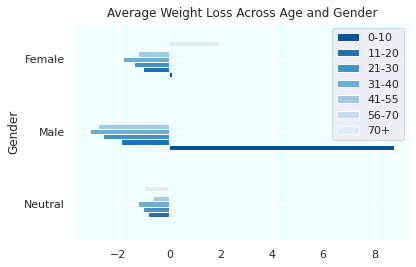

In [226]:
# importing package
import matplotlib.pyplot as plt
import seaborn as sns

col = sns.color_palette("Blues_r", 7)
# plot grouped bar chart

gender.plot(x='Gender',
		kind='barh',
    color=col,
		stacked=False,
		title='Average Weight Loss Across Age and Gender')
ax = plt.gca()

ax.set_facecolor('azure')


In [179]:
df[df['gendar'] == 2].count()

Unnamed: 0             272874
user_id                272874
cutoff                 272874
avatar                 272874
gendar                 272874
height                 272874
target_weight          272874
lastdays               272874
AvgPost                272874
AvgComment             272874
AvgMention             272874
age                    272874
hasPost                272874
hasComment             272874
hasMention             272874
hasHeight              272874
hasWeightTarget        272874
birthday               272874
location                70239
weight_x               272874
target_date            272874
latest_weight          272874
bmi                    272874
created_at             272874
calory_intake_freq     272874
daily_post_count       272874
daily_comment_count    272874
spend_per_order        272874
order_counts           272874
weight_y               272874
record_on              272874
date                   272874
agerange               272874
intake_bac

In [198]:
df[df['gendar'] == 0].count()

Unnamed: 0             3282
user_id                3282
cutoff                 3282
avatar                 3282
gendar                 3282
height                 3282
target_weight          3282
lastdays               3282
AvgPost                3282
AvgComment             3282
AvgMention             3282
age                    3282
hasPost                3282
hasComment             3282
hasMention             3282
hasHeight              3282
hasWeightTarget        3282
birthday               3282
location                512
weight_x               3282
target_date            3282
latest_weight          3282
bmi                    3282
created_at             3282
calory_intake_freq     3282
daily_post_count       3282
daily_comment_count    3282
spend_per_order        3282
order_counts           3282
weight_y               3282
record_on              3282
date                   3282
agerange               3282
intake_back            3282
post_back              3282
comment_back        